In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
from snntorch import spikegen, surrogate
import matplotlib.pyplot as plt
from utils import load_dataset_df, smile_to_fp_mix, smile_to_fp, data_splitter, get_spiking_net, make_filename
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score
from csnn_model import CSNNet, get_prediction_fn

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

In [2]:
#!pip install pandas numpy rdkit torch snntorch matplotlib scikit-learn deepchem pubchempy

In [3]:
#https://github.com/chainer/chainer-chemistry/blob/master/chainer_chemistry/dataset/splitters/scaffold_splitter.py

#splitter = ScaffoldSplitter()
#tasks, datasets, transformers = dc.molnet.load_bbbp(splitter=splitter, featurizer="ECFP", reload=True)
#train, val, test = datasets

#### Load DataFrame

In [4]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[0]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


NR-AR 7265 0.04
NR-AR-LBD 6758 0.04
NR-AhR 6549 0.12
NR-Aromatase 5821 0.05
NR-ER 6193 0.13
NR-ER-LBD 6955 0.05
NR-PPAR-gamma 6450 0.03
SR-ARE 5832 0.16
SR-ATAD5 7072 0.04
SR-HSE 6467 0.06
SR-MMP 5810 0.16
SR-p53 6774 0.06


In [5]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### SMILE to Fingerprint

In [6]:
fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['pubchem', 881]]
fp_type, num_bits = fp_types[1]
#num_bits = 2048
fp_config = {"fp_type": fp_type,
             "num_bits": num_bits,
             "radius": 2,
             "fp_type_2": fp_types[0][0],
             "num_bits_2": 1024 - num_bits,
             "mix": True,
             }

print(fp_type, '-', num_bits)

maccs - 167


In [7]:
dtype = torch.float32
split = "scaffold"
dataset = None

if dirname != 'BBBP':
    split = "random"
    if fp_config['mix']:
        fp_array, target_array = smile_to_fp_mix(df, fp_config=fp_config, target_name=target_name)
    else:
        fp_array, target_array = smile_to_fp(df, fp_config=fp_config, target_name=target_name)
    # Create Torch Dataset
    fp_tensor = torch.tensor(fp_array, dtype=dtype)
    target_tensor = torch.tensor(target_array, dtype=dtype).long()

    dataset = TensorDataset(fp_tensor, target_tensor)

[01:06:10] Explicit valence for atom # 8 Al, 6, is greater than permitted
[01:06:11] Explicit valence for atom # 3 Al, 6, is greater than permitted
[01:06:11] Explicit valence for atom # 4 Al, 6, is greater than permitted
[01:06:12] Explicit valence for atom # 4 Al, 6, is greater than permitted
[01:06:13] Explicit valence for atom # 9 Al, 6, is greater than permitted
[01:06:14] Explicit valence for atom # 5 Al, 6, is greater than permitted
[01:06:15] Explicit valence for atom # 16 Al, 6, is greater than permitted


In [8]:
print(fp_array.shape)

(5825, 1024)


#### Loss Function

In [9]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['ce_mem', 'rate_loss', 'count_loss', 'temporal_loss', 'bce_loss']
loss_type = loss_types[2]
print(loss_type)


count_loss


#### Train Loop

In [10]:
net_types = ["SNN", "DSNN", "CSNN"]
net_type = net_types[2]
#spike_grad = surrogate.sigmoid(slope=25)
spike_grad = None
beta = 0.95 #experimentar 0.7

net_config = {"input_size": 1024 if fp_config['mix'] else num_bits,
              "num_hidden": 512,
              "num_hidden_l2": 256,
              "use_l2": net_type == "DSNN",
              "time_steps": 10,
              "spike_grad": spike_grad,
              "beta": beta,
              "encoding": 'rate',
              "out_num": 2
              }
pop_coding = net_config['out_num'] > 2

fast sigmoid / sigmoid
lr = 1e-5 ou -6, com 500-1000 epochs
batch size 16
batches devem incluir pos e neg samples
Adamax

experimentar com Tox21 NR-AR
temporal coding se não aumentar com rate coding

ver oversampling 

In [11]:
lr=1e-4 #1e-6 default for 1000 epochs. csnn requires higher
iterations = 30
weight_decay = 0 # 1e-5
optim_type = 'Adam'
#optim_type = 'SGD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16 #16, 8
train_config = {"num_epochs": 1000,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['time_steps'],
                'val_net': None,
                'prediction_fn': get_prediction_fn(encoding=net_config['encoding'], pop_coding=pop_coding),
                }
drop_last = net_type == "CSNN"
pin_memory = device == "cuda"
save = True
results = [[], [], [], [], [], []]

cuda


In [12]:
from rdkit import RDLogger

# Disable RDKit logging for the scaffold meeting
RDLogger.DisableLog('rdApp.*')


In [13]:
def calc_metrics(metrics_list, all_targets, all_preds):

    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    
    print('acc:', accuracy,' auc:', auc_roc)
    metrics_list[0].append(accuracy)
    metrics_list[1].append(auc_roc)
    metrics_list[2].append(sensitivity)
    metrics_list[3].append(specificity)
    metrics_list[4].append(f1)
    metrics_list[5].append(precision)
    

In [ ]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    #seed = random.randint(1, 30)
    seed = iter + 1
    print(f"Seed:{seed}")
    random.seed(seed)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config['num_epochs'])
    #optimizer = torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #train_config["scheduler"] = scheduler

    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, fp_config=fp_config, seed=seed, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1], dtype=np.int8), y=np.array(train_label, dtype=np.int8))
    #class_weights[0] = class_weights[0]/2
    #class_weights[0] = class_weights[0]*2

    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)

    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights, pop_coding=pop_coding)


    # TRAINING
    net, loss_hist, val_acc_hist, val_auc_hist, net_list = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config, net_config=net_config)
    print('best val set auc:', max(val_auc_hist))
    # TESTING
    model = net
    best_test_auc = 0
    best_epoch = 0
    for index, model_dict in enumerate(net_list):
        model.load_state_dict(model_dict)
        model.to(device)
        all_preds2, all_targets2 = test_net(model, device, test_loader, train_config)
        auc_roc_test = roc_auc_score(all_targets2, all_preds2)
        if auc_roc_test > best_test_auc:
            best_test_auc, best_epoch = (auc_roc_test, index)

    model.load_state_dict(net_list[best_epoch])
    filename = make_filename(dirname, target_name, net_type, fp_config, lr, weight_decay, optim_type, net_config, train_config, model, model=True)
    torch.save(model.state_dict(), filename.removesuffix('.csv') + f"seed-{seed}" +'.pth')
    all_preds, all_targets = test_net(model, device, test_loader, train_config)
    calc_metrics(results, all_preds=all_preds, all_targets=all_targets)

Iteration:1/30
Seed:1
best val set auc: 0.6774962050936078
acc: 0.7869415807560137  auc: 0.7381280747617381
Iteration:2/30
Seed:2
best val set auc: 0.7550276654607362
acc: 0.7508591065292096  auc: 0.749569288769078
Iteration:3/30
Seed:3
best val set auc: 0.7312218679669918
acc: 0.761168384879725  auc: 0.7236240975263344
Iteration:4/30
Seed:4
best val set auc: 0.7066390041493776
acc: 0.8058419243986255  auc: 0.7340731707317074
Iteration:5/30
Seed:5
best val set auc: 0.7494845360824743
acc: 0.7268041237113402  auc: 0.7558743760968161
Iteration:6/30
Seed:6
best val set auc: 0.7702923422890283
acc: 0.7336769759450171  auc: 0.7311311876529267
Iteration:7/30
Seed:7
best val set auc: 0.7272229766706528
acc: 0.7852233676975945  auc: 0.7105917104276069
Iteration:8/30
Seed:8
best val set auc: 0.7705189547294811
acc: 0.718213058419244  auc: 0.7156018667524944
Iteration:9/30
Seed:9


In [ ]:
#Save the best model
#torch.save(model.state_dict(), models//)
# se for preciso, continuar o treino
print('best val set auc:', max(val_auc_hist))
print(model.lif1.threshold)
print(model.lif_out.threshold)

best val set auc: 0.7461742708312221
Parameter containing:
tensor(1.3189, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.7034, device='cuda:0', requires_grad=True)


#### Smoothed Loss

C:\Users\knsve\AppData\Local\Temp\ipykernel_21076\4265383385.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


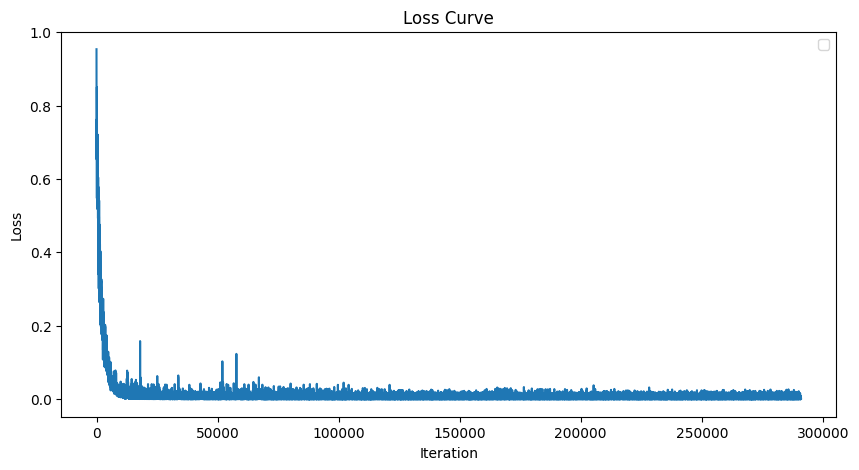

In [ ]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

#print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
#plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

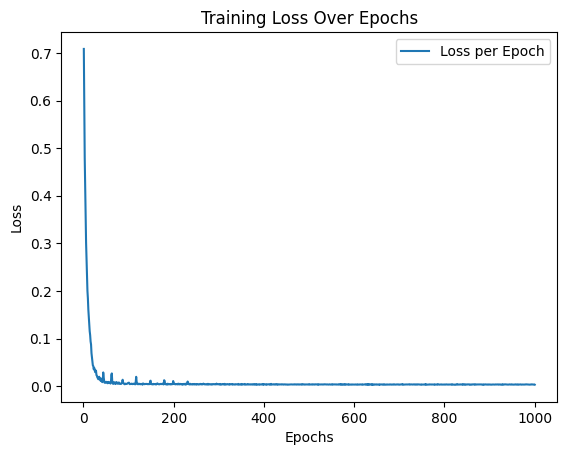

In [17]:
num_epochs = train_config['num_epochs']
num_minibatches_per_epoch = len(loss_hist) // num_epochs

# Create x-axis values in terms of epochs
epochs = np.linspace(1, num_epochs, len(loss_hist))
epoch_losses = np.array(loss_hist).reshape(num_epochs, num_minibatches_per_epoch).mean(axis=1)

plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

C:\Users\knsve\AppData\Local\Temp\ipykernel_21076\1552820167.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


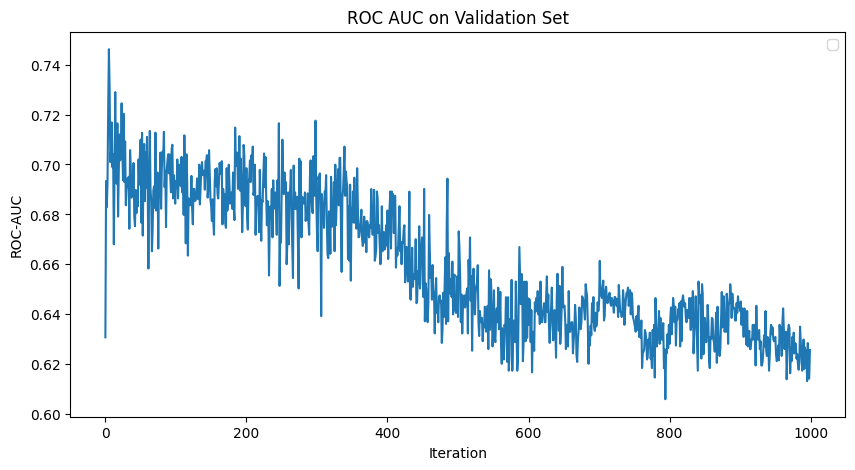

In [18]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

#plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.plot(val_auc_hist)
plt.title("ROC AUC on Validation Set")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [19]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']


filename = make_filename(dirname, target_name, net_type, fp_config, lr, weight_decay, optim_type, net_config, train_config, model)
if save: df_metrics.to_csv(filename, index=False)

print(filename)

Accuracy:  0.854 ± 0.000
AUC ROC: 0.727 ± 0.000
Sensitivity: 0.547 ± 0.000
Specificity: 0.907 ± 0.000
results\tox21\SR-ARE_CSNN_beta-0.95_maccs_morgan_1024_out-8_kernel-3_stride-1_t10_e1000_b16_lr0.0001_count_loss_Adam_wd0_pop.csv


In [20]:
#from torchsummary import summary
#summary(net, input_size=(1, 1024),  batch_size=32)

#from torchinfo import summary

#summary(net, input_size=(batch_size, 1, 1024), verbose=0)